# Implementation of SGD with stress as loss function for visualization of temporal graphs

In [1]:
from HotVisFunctions import *
import csv

/opt/conda/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## Shortest paths of PathData

To be able o use the algorithm also for PathData, we need a function wich returns the distance matrix of a Pathdata object.

In [21]:
def shortest_paths_path_data(path_data: pp.PathData):

    # create second order model
    mo_graph = pp.MultiOrderModel.from_PathData(path_data, max_order=2, cached=True)
    # create distance matrix for all nodes: default value is 'inf'
    dist = torch.full((mo_graph.layers[1].n, mo_graph.layers[1].n), float('inf'))
    # get distances of second order model
    mo_dist, _ = pp.algorithms.shortest_paths.shortest_paths_dijkstra(mo_graph.layers[2])
    # iterate through values adjancecy matrix
    for i in range(mo_dist.shape[0]):
        for j in range(mo_dist.shape[0]):
                # get node ids
                node_i = mo_graph.layers[2].mapping.node_ids[i]
                node_j = mo_graph.layers[2].mapping.node_ids[j]
                if(dist[path_data.mapping.to_idx(node_i[0]), path_data.mapping.to_idx(node_j[1])] > mo_dist[i,j] + 1):
                    # write distance into 'dist'
                    dist[path_data.mapping.to_idx(node_i[0]), path_data.mapping.to_idx(node_j[1])] = mo_dist[i,j] + 1
    
    # insert all distances of length 1
    for node in mo_graph.layers[2].nodes:
        dist[path_data.mapping.to_idx(node[0]), path_data.mapping.to_idx(node[1])] = 1

    # fill diagonals with 0
    torch.Tensor.fill_diagonal_(dist, 0)

    return dist

We test the function from above and the ``` pp.algorithms.temporal_shortest_paths``` on simple examples.

In [25]:
g = pp.Graph.from_edge_list([('a', 'b'), ('b','c'), ('b','d')])
test_path_data = pp.PathData(g.mapping)
test_path_data.append_walk(('a', 'b', 'c'))
test_path_data.append_walk(('b', 'd'))
test_path_data.append_walk(('b', 'a'))

test_temp_graph =pp.TemporalGraph.from_edge_list([('a', 'b', 1), ('b', 'c', 1), ('b', 'a', 2), ('b', 'd', 1)])
dist, _ = pp.algorithms.temporal_shortest_paths(test_temp_graph, 1)
print(dist)
print(test_temp_graph.mapping)
print(shortest_paths_path_data(test_path_data))

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 264.34it/s]

[[ 0.  1. inf inf]
 [ 1.  0.  1.  1.]
 [inf inf  0. inf]
 [inf inf inf  0.]]
a -> 0
b -> 1
c -> 2
d -> 3

tensor([[0., 1., 2., inf],
        [1., 0., 1., 1.],
        [inf, inf, 0., inf],
        [inf, inf, inf, 0.]])


It is easy to see, that the functions output correct matrices.

## Implementation of the algorithm

At first, we implement the stress function. It should be able to get torch.nn.Embedding and torch.Tensor as input.

In [4]:
def stress_loss(layout: torch.nn.Embedding|torch.Tensor, shortest_path_dist: torch.Tensor) -> float:
    loss = 0

    if isinstance(layout, torch.nn.Embedding):
        for i in range(layout.num_embeddings):
            for j in range(i + 1, layout.num_embeddings):
                delta = layout(torch.tensor(i)) - layout(torch.tensor(j))
                distance = torch.norm(delta)
                loss += ((distance - shortest_path_dist[i, j])/shortest_path_dist[i, j]) ** 2  

    elif isinstance(layout, torch.Tensor):
        for i in range(layout.shape[0]):
            for j in range(i + 1, layout.shape[0]):
                delta = layout[i] - layout[j]
                distance = torch.norm(delta)
                loss += ((distance - shortest_path_dist[i, j])/shortest_path_dist[i, j]) ** 2  
    else:
        return None

    return loss

Then we implement a version using the torch libary. This version slightly differs from the one of paper. This is because the papers version can't be implemented using the classic torch trainingloop. Additionally we implement a version using the adam oprimizer instead of SGD.

In [5]:
def SGD_stress_torch(data: pp.TemporalGraph|pp.PathData, iterations: int, delta: int = 1, learning_rate: float = 0.01, initial_positions: torch.Tensor | None = None) -> dict:

    # dependent on input type, get graph for wich we need the layout and distance matrix
    if isinstance(data, pp.TemporalGraph):
        graph = data
        dist, _ = pp.algorithms.temporal_shortest_paths(graph, delta)
    elif isinstance(data, pp.PathData):
        graph = pp.MultiOrderModel.from_PathData(data, max_order=1).layers[1]
        dist = shortest_paths_path_data(path_data=data)
    else:
        return {}
    
    if(torch.isinf(dist).any()):
        print("Error: The graph or PathData isn't connected.")
        return {}

    # initialize embedding
    num_nodes =  graph.n 
    embedding_dim = 2     
    embedding = torch.nn.Embedding(num_nodes, embedding_dim)

    # initialize initial_positions
    if not initial_positions is None:
        with torch.no_grad(): 
            embedding.weight = torch.nn.Parameter(initial_positions)
    else:
        initial_positions = torch.rand((graph.n, 2))*100
        embedding.weight = torch.nn.Parameter(initial_positions)


    # define optimizer and learning rate scheduler
    optimizer = torch.optim.SGD(embedding.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999999)

    # training loop
    for i in range(iterations):
        loss = stress_loss(embedding, dist)
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        scheduler.step()

        # show loss
        if (i+1) % 10 == 0:
            print(f"Epoch [{i+1}/{iterations}], Loss: {loss.item():.4f}")

    # create layout out of embedding
    layout = {}
    for node in graph.nodes:
        layout[node] = embedding(torch.tensor(graph.mapping.to_idx(node))).tolist()

    return layout


def Adam_stress_torch(data: pp.TemporalGraph|pp.PathData, iterations: int, delta: int = 1, learning_rate: float = 0.01, initial_positions: torch.Tensor | None = None):

    # dependent on input type, get graph for wich we need the layout and distance matrix
    if isinstance(data, pp.TemporalGraph):
        graph = data
        dist, _ = pp.algorithms.temporal_shortest_paths(graph, delta)
    elif isinstance(data, pp.PathData):
        graph = pp.MultiOrderModel.from_PathData(data, max_order=1).layers[1]
        dist = shortest_paths_path_data(path_data=data)
    else:
        return {}

    if(torch.isinf(dist).any()):
        print("Error: The graph or PathData isn't connected.")
        return {}

    # initialize embedding
    num_nodes =  graph.n 
    embedding_dim = 2     
    embedding = torch.nn.Embedding(num_nodes, embedding_dim)

    # initialize initial_positions
    if not initial_positions is None:
        with torch.no_grad(): 
            embedding.weight = torch.nn.Parameter(initial_positions)
    else:
        initial_positions = torch.rand((graph.n, 2))*100
        embedding.weight = torch.nn.Parameter(initial_positions)


    # define optimizer and lossfunction
    optimizer = torch.optim.Adam(embedding.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999999)

    # training loop
    for i in range(iterations):
        loss = stress_loss(embedding, dist)
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        scheduler.step()

        # show loss
        if (i+1) % 10 == 0:
            print(f"Epoch [{i+1}/{iterations}], Loss: {loss.item():.4f}")
            
    # create layout out of embedding
    layout = {}
    for node in graph.nodes:
        layout[node] = embedding(torch.tensor(graph.mapping.to_idx(node))).tolist()

    return layout



Additionally we implement a version wich follows exactly the paper. Thois one might converge faster in less epochs, but every epoch has longer runtime.

In [6]:
def SGD_stress_paper(data: pp.TemporalGraph|pp.PathData, iterations: int, delta:int = 1, initial_positions: torch.Tensor | None = None, learning_rate: float = 0.01, eta: float = 1, decay: float = 0.5) -> dict:
    
     # dependent on input type, get graph for wich we need the layout and distance matrix
    if isinstance(data, pp.TemporalGraph):
        graph = data
        dist, _ = pp.algorithms.temporal_shortest_paths(graph, delta)
    elif isinstance(data, pp.PathData):
        graph = pp.MultiOrderModel.from_PathData(data, max_order=1).layers[1]
        dist = shortest_paths_path_data(path_data=data)
    else:
        return {}
    
    if(torch.isinf(dist).any()):
        print("Error: The graph or PathData isn't connected.")
        return {}
    
    # initialize initial_positions if not given
    if initial_positions is None:
        initial_positions = torch.rand((graph.n, 2))*100
    
    positions = torch.clone(initial_positions)

    # get all possible node pairs
    node_pairs = torch.combinations(torch.arange(graph.n), r=2, with_replacement=False)

    for i in range(iterations):
        # shuffle order of node pairs
        shuffled_pairs = node_pairs[torch.randperm(node_pairs.size(0))]
        # calculate step width (called eta in paper)
        step_width = eta * torch.exp(torch.tensor(-decay * i))

        # iterate through node pairs
        for pair in shuffled_pairs:
            # get distance between pairs
            shortest_path_dist = dist[pair[0], pair[1]]
            # skip if nodes are the same
            if(shortest_path_dist == 0):
               continue
            # calculate learning rate
            learning_rate = min(1, ((1 / (shortest_path_dist ** 2)) * step_width)) / 2
            # calculate distance of nodes in layout (not in graph)
            norm = torch.norm(positions[pair[0]] - positions[pair[1]])
            # determine distace and dirction the nodes are moved 
            delta = (norm - shortest_path_dist) / norm * (positions[pair[0]] - positions[pair[1]])
            positions[pair[0]] -= learning_rate * delta
            positions[pair[1]] += learning_rate * delta

        # show loss
        if (i+1) % 10 == 0:
            print(f"Epoch [{i+1}/{iterations}], Stress: {stress_loss(positions, dist):.4f}")

    # create layout 
    layout = {}
    for node in graph.nodes:
        layout[node] = positions[graph.mapping.to_idx(node)].tolist()

    return layout

## Test

Next we test the algorithms on a graph

In [7]:
graph = pp.io.read_csv_temporal_graph('graphs/synthetic_graph/temporal_clusters_real_kregular.tedges', is_undirected = True, timestamp_format='%S')
# read colors
colors = {}
with open('graphs/synthetic_graph/colors.csv', mode="r") as file:
    reader = csv.reader(file)
    next(reader)  # Überspringt die Kopfzeile
    for row in reader:
        number, color = row
        colors[number] = color
style = {}
style['node_color'] = colors
style['node_size'] = 10
style['edge_size'] = 0.1

In [73]:
layout_paper = SGD_stress_paper(graph, iterations=30, delta = 1, learning_rate=0.01)
layout_adam = Adam_stress_torch(graph, iterations=500, delta = 1, learning_rate=0.5)
layout_torch = SGD_stress_torch(graph, iterations=100, delta = 1, learning_rate=0.01)

100%|██████████| 20000/20000 [00:09<00:00, 2092.31it/s]


Epoch [10/30], Stress: 66.9190
Epoch [20/30], Stress: 66.8975
Epoch [30/30], Stress: 66.8974


100%|██████████| 20000/20000 [00:10<00:00, 1946.78it/s]


Epoch [10/500], Loss: 1160629.5000
Epoch [20/500], Loss: 832542.4375
Epoch [30/500], Loss: 584393.4375
Epoch [40/500], Loss: 401475.8750
Epoch [50/500], Loss: 270023.6250
Epoch [60/500], Loss: 177801.2500
Epoch [70/500], Loss: 114674.2031
Epoch [80/500], Loss: 72520.6094
Epoch [90/500], Loss: 44996.2422
Epoch [100/500], Loss: 27384.8516
Epoch [110/500], Loss: 16337.6377
Epoch [120/500], Loss: 9550.9033
Epoch [130/500], Loss: 5471.3481
Epoch [140/500], Loss: 3074.9883
Epoch [150/500], Loss: 1702.2004
Epoch [160/500], Loss: 935.7991
Epoch [170/500], Loss: 519.1172
Epoch [180/500], Loss: 298.4307
Epoch [190/500], Loss: 184.3327
Epoch [200/500], Loss: 126.4841
Epoch [210/500], Loss: 97.5439
Epoch [220/500], Loss: 83.1026
Epoch [230/500], Loss: 75.8003
Epoch [240/500], Loss: 72.0100
Epoch [250/500], Loss: 69.9877
Epoch [260/500], Loss: 68.8697
Epoch [270/500], Loss: 68.2191
Epoch [280/500], Loss: 67.8059
Epoch [290/500], Loss: 67.5260
Epoch [300/500], Loss: 67.3372
Epoch [310/500], Loss: 67

100%|██████████| 20000/20000 [00:09<00:00, 2037.82it/s]


Epoch [10/100], Loss: 68.7358
Epoch [20/100], Loss: 66.9718
Epoch [30/100], Loss: 66.8525
Epoch [40/100], Loss: 66.7988
Epoch [50/100], Loss: 66.7751
Epoch [60/100], Loss: 66.7645
Epoch [70/100], Loss: 66.7581
Epoch [80/100], Loss: 66.7524
Epoch [90/100], Loss: 66.7461
Epoch [100/100], Loss: 66.7392


All algorithms cnverge to a similar value. This is an indicator that they work.

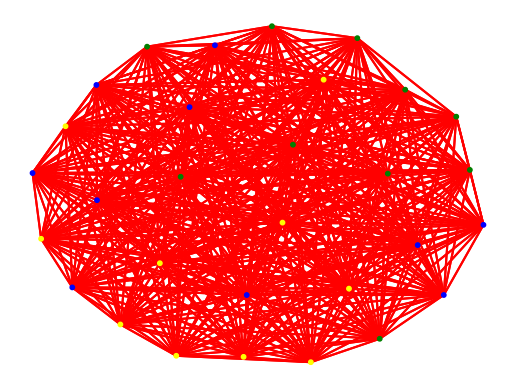

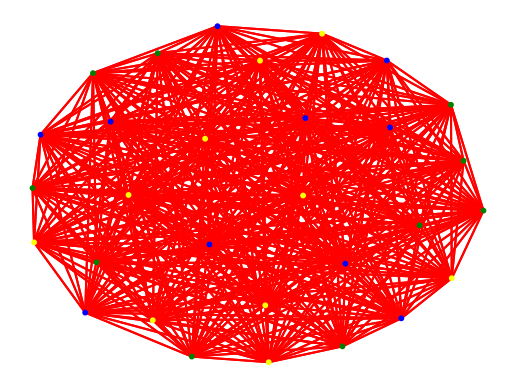

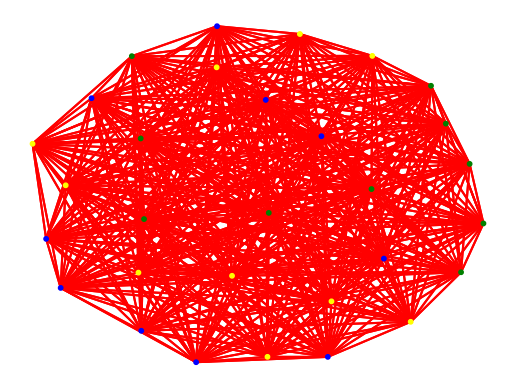

In [74]:
pp.plot(graph.to_static_graph(), layout=layout_adam, backend='matplotlib', **style)
pp.plot(graph.to_static_graph(), layout=layout_torch, backend='matplotlib', **style)
pp.plot(graph.to_static_graph(), layout=layout_paper, backend='matplotlib', **style)

Next we test the algorithms on path data.

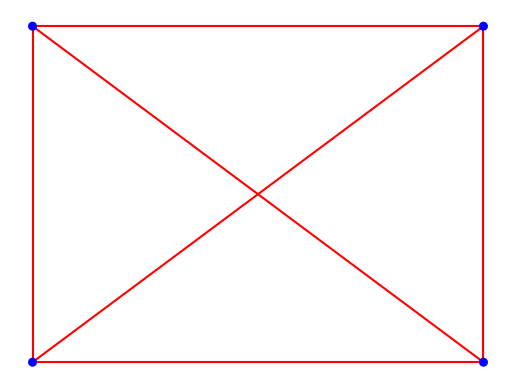

In [13]:
tedges = [('a', 'b', 1), ('b', 'c', 3), ('d', 'c', 4)]
test_graph = pp.TemporalGraph.from_edge_list(tedges)
test_layout= {'a':[0,0], 'b':[1,0], 'c':[0,1], 'd':[1,1]}

# create PathData object with same structure
test_paths = pp.PathData(test_graph.mapping)


test_paths.append_walk(['a', 'b', 'd', 'c', 'a', 'b', 'd'])
test_paths.append_walk(['a', 'd', 'b', 'c'])


test_m = pp.MultiOrderModel.from_PathData(test_paths, 2, cached=True)
pp.plot(test_m.layers[1], layout=test_layout, backend="matplotlib")

In [23]:
layout_paper = SGD_stress_paper(test_paths, iterations=30, delta = 1, learning_rate=0.01)
layout_adam = Adam_stress_torch(test_paths, iterations=500, delta = 1, learning_rate=0.5)
layout_torch = SGD_stress_torch(test_paths, iterations=100, delta = 1, learning_rate=0.01)

Epoch [10/30], Stress: 8.5588
Epoch [20/30], Stress: 8.3458
Epoch [30/30], Stress: 8.3446
Epoch [10/500], Loss: 6917.3677
Epoch [20/500], Loss: 4697.0615
Epoch [30/500], Loss: 3215.7246
Epoch [40/500], Loss: 2187.0310
Epoch [50/500], Loss: 1460.2625
Epoch [60/500], Loss: 950.2629
Epoch [70/500], Loss: 595.3645
Epoch [80/500], Loss: 360.0478
Epoch [90/500], Loss: 210.8195
Epoch [100/500], Loss: 119.3900
Epoch [110/500], Loss: 65.3565
Epoch [120/500], Loss: 34.5510
Epoch [130/500], Loss: 17.6615
Epoch [140/500], Loss: 8.7679
Epoch [150/500], Loss: 4.2846
Epoch [160/500], Loss: 2.1267
Epoch [170/500], Loss: 1.1340
Epoch [180/500], Loss: 0.6904
Epoch [190/500], Loss: 0.4856
Epoch [200/500], Loss: 0.3761
Epoch [210/500], Loss: 0.3068
Epoch [220/500], Loss: 0.2615
Epoch [230/500], Loss: 0.2332
Epoch [240/500], Loss: 0.2157
Epoch [250/500], Loss: 0.2047
Epoch [260/500], Loss: 0.1979
Epoch [270/500], Loss: 0.1938
Epoch [280/500], Loss: 0.1914
Epoch [290/500], Loss: 0.1900
Epoch [300/500], Loss

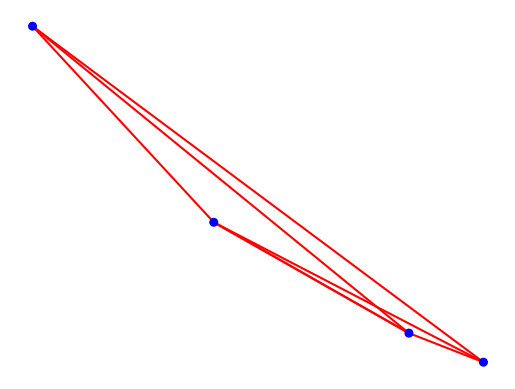

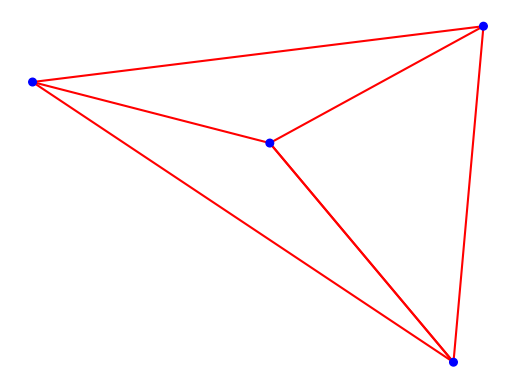

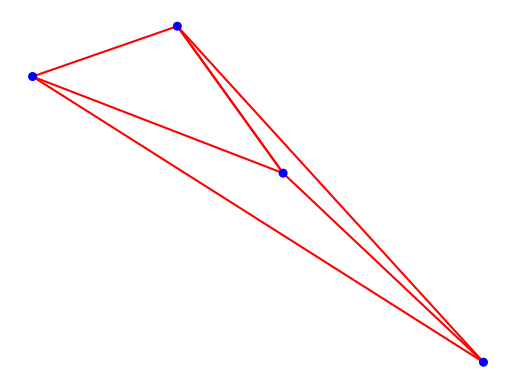

In [24]:
pp.plot(test_m.layers[1], layout=layout_paper, backend="matplotlib")
pp.plot(test_m.layers[1], layout=layout_adam, backend="matplotlib")
pp.plot(test_m.layers[1], layout=layout_torch, backend="matplotlib")